# Sports Image Classification

## A.1 Download & Inspect the Data
- **A.1.1** Inspect the data layout  
- **A.1.2** Decide on the DataBlock design

In [ ]:
# Step 1.1: Mount Drive & Inspect Dataset Layout

from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# 1. Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Train images: 8237
Test  images: 2056

train.csv sample:


,image_ID,label
0,7c225f7b61.jpg,Badminton
1,b31.jpg,Badminton
2,acb146546c.jpg,Badminton
3,0e62f4d8f2.jpg,Badminton
4,cfd2c28c74.jpg,Cricket



test.csv sample:


,image_ID
0,f5e13966e7.jpg
1,6674191b4e.jpg
2,91b5f8b7a9.jpg
3,393119b6d6.jpg
4,1ce5f81578.jpg



Class counts in train:


,count
label,
Cricket,1556
Wrestling,1471
Tennis,1445
Badminton,1394
Soccer,1188
Swimming,595
Karate,578


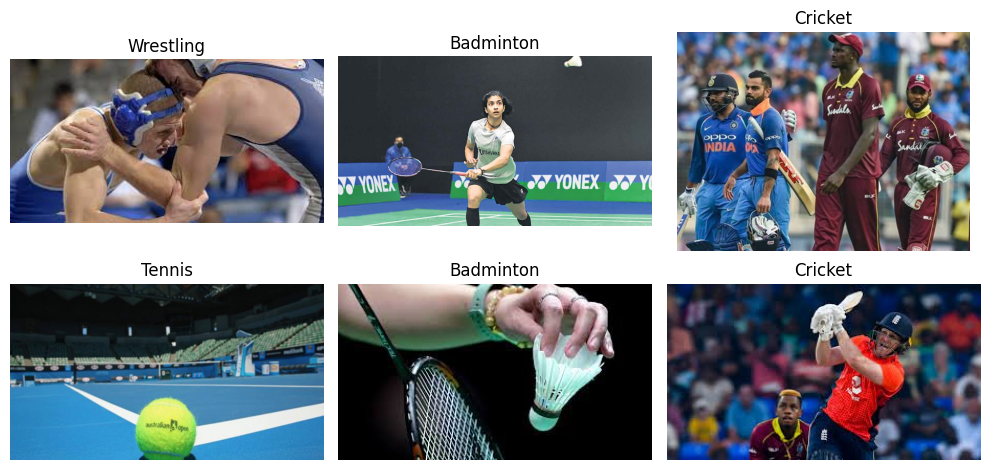

In [ ]:
from pathlib import Path

# 2. Paths
BASE       = '/content/drive/MyDrive/ADA447/dataset'
TRAIN_DIR  = os.path.join(BASE, 'train')
TEST_DIR   = os.path.join(BASE, 'test')
TRAIN_CSV  = os.path.join(BASE, 'train.csv')
TEST_CSV   = os.path.join(BASE, 'test.csv')

# Models will be saved to this path:
model_path = Path("/content/drive/MyDrive/ada_mt/models")
model_path.mkdir(exist_ok=True)  # Create folder if it doesn't exist

# 3. Quick folder listing & counts
print(f"Train images: {len(os.listdir(TRAIN_DIR))}")
print(f"Test  images: {len(os.listdir(TEST_DIR))}")

# 4. Peek at CSVs
df_train = pd.read_csv(TRAIN_CSV)
df_test  = pd.read_csv(TEST_CSV)
print("\ntrain.csv sample:")
display(df_train.head())
print("\ntest.csv sample:")
display(df_test.head())

# 5. Class distribution
print("\nClass counts in train:")
display(df_train['label'].value_counts())

# 6. Visual sanity check: 6 random samples
plt.figure(figsize=(10,5))
for i, (img, lbl) in enumerate(df_train.sample(6).values):
    im = Image.open(os.path.join(TRAIN_DIR, img))
    plt.subplot(2,3,i+1)
    plt.imshow(im)
    plt.title(lbl)
    plt.axis('off')
plt.tight_layout()
plt.show()

## A.2 Create DataBlock & DataLoaders

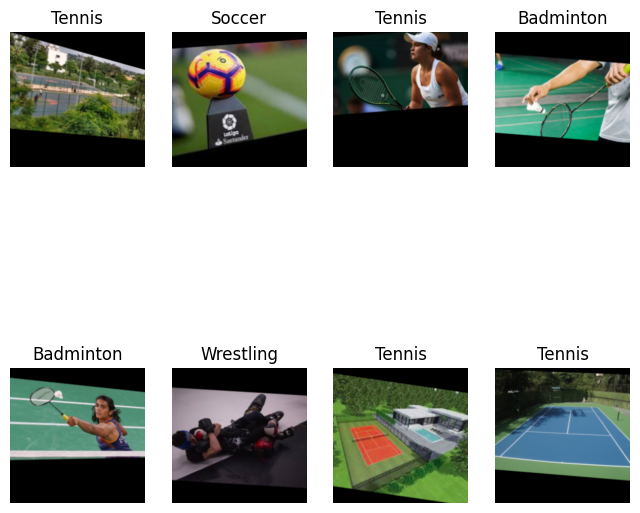

In [ ]:
from fastai.vision.all import *

# 1. Reload your train dataframe
df = pd.read_csv(TRAIN_CSV)

# 2. Define the DataBlock
sports_block = DataBlock(
    # A.2.1 Blocks: images in, categories out
    blocks=(ImageBlock, CategoryBlock),
    # A.2.2 How to get inputs
    get_x=ColReader('image_ID', pref=TRAIN_DIR + os.path.sep),
    # A.2.3 How to get labels
    get_y=ColReader('label'),
    # split 80/20
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # A.2.4 Presizing + item transforms
    item_tfms=Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    # A.2.4 Batch transforms: augment at 256px → down-size → normalize
    batch_tfms=[
        *aug_transforms(size=256, min_scale=0.75),
        Resize(224),
        Normalize.from_stats(*imagenet_stats)
    ]
)

# 3. Create DataLoaders
dls = sports_block.dataloaders(df, bs=64)

# 4. Inspect
print(dls)
dls.show_batch(max_n=8, figsize=(8,8))

## A.3 Inspect the DataBlock via DataLoaders  


- A.3.1 Show batch: dataloader.show_batch()  
- A.3.2 Check the labels  
- A.3.3 Summarize the DataBlock: datablock.summary(source)  

Raw label indices: TensorCategory([3, 1, 1, 2, 4, 6, 0, 3], device='cuda:0')
Decoded labels      : ['Soccer', 'Cricket', 'Cricket', 'Karate', 'Swimming', 'Wrestling', 'Badminton', 'Soccer']


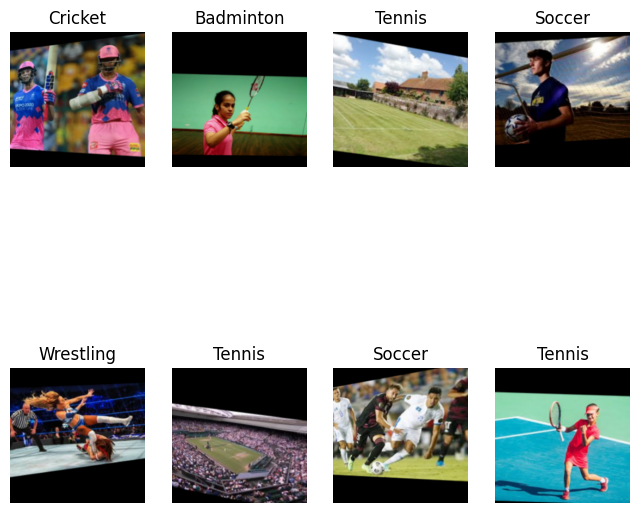

In [ ]:
# 1. Show a batch of images with labels
dls.show_batch(max_n=8, figsize=(8,8))

# 2. Check raw and decoded labels from one batch
xb, yb = dls.one_batch()
print("Raw label indices:", yb[:8])
print("Decoded labels      :", [dls.vocab[i] for i in yb[:8]])

In [ ]:
# 3. Summarize the DataBlock based on your DataFrame source
sports_block.summary(df)

Setting-up type transforms pipelines
0     7c225f7b61.jpg  Badminton
1            b31.jpg  Badminton
2     acb146546c.jpg  Badminton
3     0e62f4d8f2.jpg  Badminton
4     cfd2c28c74.jpg    Cricket
...              ...        ...
8222  903d2fffb3.jpg    Cricket
8223  b5f174c688.jpg  Badminton
8224  2433770a67.jpg     Tennis
8225  6403964166.jpg     Tennis
8226  f07f00564e.jpg   Swimming

[8227 rows x 2 columns]
Found 8227 items
2 datasets of sizes 6582,1645
Setting up Pipeline: ColReader -- {'cols': 'image_ID', 'pref': '/content/drive/MyDrive/ADA447/dataset/train/', 'suff': '', 'label_delim': None} -> PILBase.create
Setting up Pipeline: ColReader -- {'cols': 'label', 'pref': '', 'suff': '', 'label_delim': None} -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: ColReader -- {'cols': 'image_ID', 'pref': '/content/drive/MyDrive/ADA447/dataset/train/', 'suff': '', 'label_delim': None} -> PILBase.create
    starting from
      image_ID    bee072

## A.4 Train a Simple Model  


- A.4.1 Create a benchmark  
- A.4.2 Interpret the model  
- A.4.3 Confusion matrix

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.120918,0.516002,0.831611,00:22


epoch,train_loss,valid_loss,accuracy,time
0,0.461109,0.352550,0.885106,00:20
1,0.308641,0.220302,0.927660,00:20
2,0.162341,0.200147,0.933739,00:20


Model exported successfully!


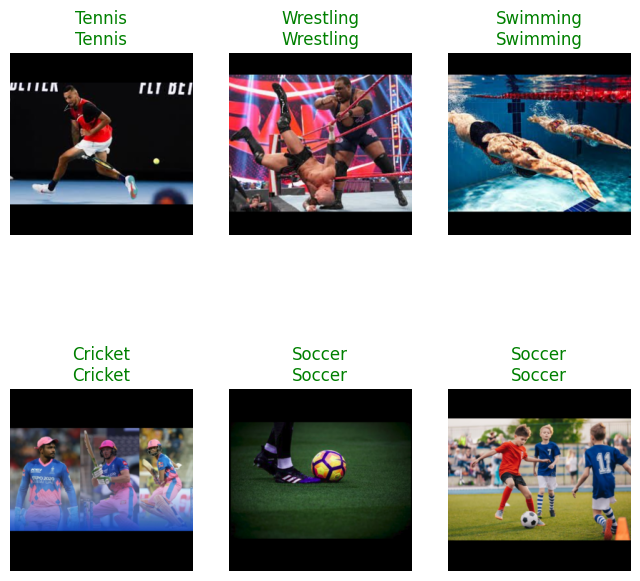

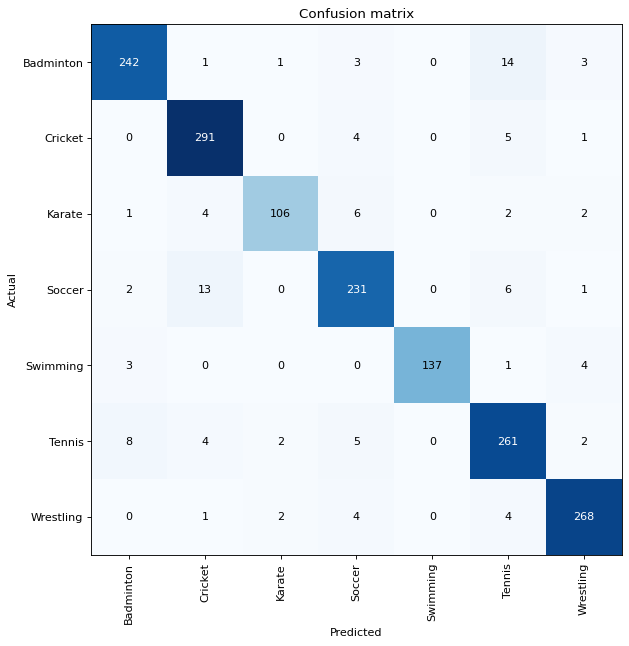

In [ ]:
from fastai.vision.all import *

# 1. A.4.1 Create a benchmark: train a simple ResNet18
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3)  # train for 3 epochs (1 frozen, 2 unfrozen)

# 2. A.4.2 Interpret the model: show sample predictions
learn.show_results(max_n=6, figsize=(8,8))

# 3. A.4.3 Confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

# Save the model
learn.export(fname=model_path/'sport_classifier_a4.pkl')  # B.7.6: Saves pretrained weights + new head
print("Model exported successfully!")

## B.1 Learning Rate Finder  


- B.1.1 Big lr: Convergence will be poor, if not impossible  
- B.1.2 Small lr: Convergence will be slow, takes too much epochs, hence overfitting  
- B.2 Finder Algorithm (fastai implementation)

Minimum gradient lr: 8.32e-07
Steepest gradient lr: 1.32e-06


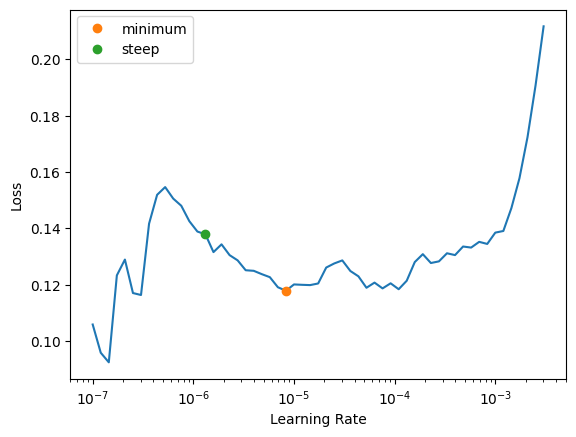

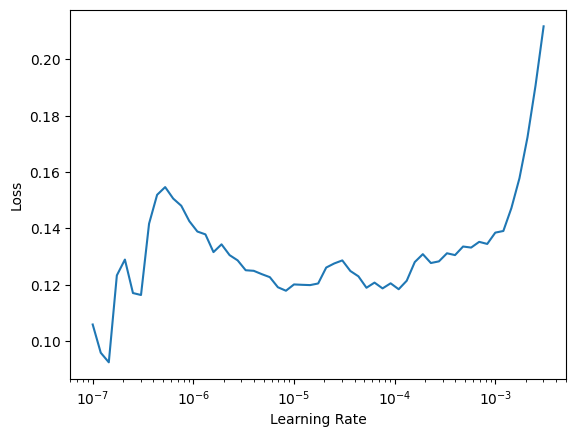

In [ ]:
# 1. Run FastAI's built-in Learning Rate Finder
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

# 2. Print suggested learning rates
print(f"Minimum gradient lr: {lr_min:.2e}")
print(f"Steepest gradient lr: {lr_steep:.2e}")

# 3. Plot the learning rate vs. loss curve for manual inspection
import matplotlib.pyplot as plt

fig = learn.recorder.plot_lr_find()
plt.show()

## B.3 Transfer Learning (Freeze & Unfreeze)

In [ ]:
from fastai.vision.all import *

# 1. Inspect the head to see the final linear layer F (mxn)
print("Original head:\n", learn.model[1])

# 2. Freeze the backbone and train only the new head F' (mxk)
learn.freeze()
# Train for 2 epochs with a reasonable LR (e.g., steepest lr from lr_find)
learn.fit_one_cycle(2, lr_max=lr_steep)

# 3. Unfreeze all layers and fine-tune with discriminative LRs
learn.unfreeze()
# Use a slice from a low LR for early layers to higher LR for the head
learn.fit_one_cycle(3, lr_max=slice(lr_min/10, lr_steep))

# Save the model
learn.export(fname=model_path/'sport_classifier_b3.pkl')  # B.7.6: Saves pretrained weights + new head
print("Model exported successfully!")

Original head:
 Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=7, bias=False)
)


epoch,train_loss,valid_loss,accuracy,time
0,0.126888,0.198717,0.930699,00:21
1,0.135362,0.194826,0.934954,00:20


epoch,train_loss,valid_loss,accuracy,time
0,0.121881,0.197838,0.931915,00:20
1,0.126435,0.198604,0.931307,00:20
2,0.128724,0.195383,0.932523,00:21


Model exported successfully!


## B.4 Discriminative Learning Rates  


- B.4.1 Early layers need smaller tweaks  
- B.4.2 New head needs larger tweaks  
- B.4.3–B.4.7 Using FastAI’s `slice` for ULMFiT-style LRs  

In [ ]:
from fastai.vision.all import *

# 1. Make sure the model is fully unfrozen
learn.unfreeze()

# 2. Apply discriminative LRs: lower LR for early layers, higher for the head
#    Assuming lr_min and lr_steep were obtained from your previous lr_find()
learn.fit_one_cycle(5, lr_max=slice(lr_min/10, lr_steep))

# Save the model
learn.export(fname=model_path/'sport_classifier_b4.pkl')  # B.7.6: Saves pretrained weights + new head
print("Model exported successfully!")

epoch,train_loss,valid_loss,accuracy,time
0,0.133068,0.197015,0.934954,00:20
1,0.124923,0.197283,0.934954,00:21
2,0.129150,0.196353,0.934346,00:20
3,0.126269,0.194022,0.933739,00:20
4,0.132988,0.196064,0.935562,00:21


Model exported successfully!


## B.5 Deciding the Number of Training Epochs  

- B.5.1 Retrain your model using the LR finder results  
- B.5.2 Avoid early stopping to not conflict with LR schedule  
- B.5.3 Choose epochs based on convergence of fine-tuning curves  

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 224MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,3.546332,2.830936,0.120973,00:20
1,3.440704,2.772706,0.127052,00:21
2,3.391246,2.721067,0.133739,00:20
3,3.364272,2.652984,0.143465,00:20
4,3.267066,2.618172,0.145897,00:21
5,3.292553,2.587650,0.156839,00:20
6,3.294776,2.579875,0.155623,00:20
7,3.292281,2.572008,0.158055,00:21


Model exported successfully!


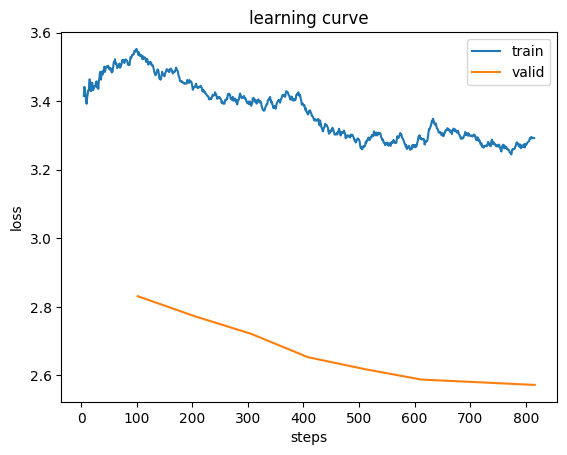

In [ ]:
# Retrain from scratch (or continue fine-tuning) using the optimal LR slice
# Replace `n_epochs` with a reasonable value (e.g. 5–10) based on your lr_find curve

# Example: Fine-tune for 8 epochs with discriminative rates
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(8, lr_max=slice(lr_min/10, lr_steep))

# Inspect the training & validation loss curves to confirm convergence:
learn.recorder.plot_loss()

# Save the model
learn.export(fname=model_path/'sport_classifier_b5.pkl')  # B.7.6: Saves pretrained weights + new head
print("Model exported successfully!")

## B.6 Model Capacity   

- B.6.1 Decrease batch size when increasing model size  
- B.6.2 Avoid GPU OOM  
- B.6.3 Enable mixed-precision training  

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,3.254821,2.615166,0.156231,00:21


epoch,train_loss,valid_loss,accuracy,time
0,3.262757,2.645346,0.163526,00:22
1,3.133302,2.436462,0.188450,00:21
2,3.056871,2.382596,0.213982,00:21
3,2.909551,2.276246,0.223100,00:21
4,2.870735,2.280148,0.220061,00:21


Model exported successfully!


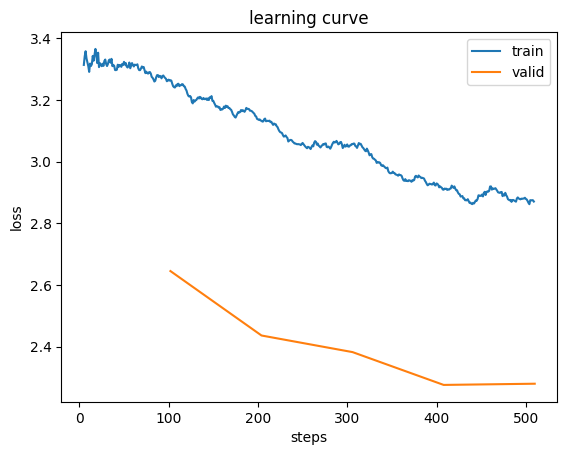

In [ ]:
from fastai.vision.all import *

learn_big = vision_learner(dls, resnet50, metrics=accuracy).to_fp16()

# 1) Freeze only the new head and train it for 1 epoch
learn_big.freeze()
learn_big.fit_one_cycle(1, lr_max=lr_steep)

# 2) Unfreeze all layers and fine-tune with your discriminative LR slice
learn_big.unfreeze()
learn_big.fit_one_cycle(5, lr_max=slice(lr_min/10, lr_steep))

# 3) Plot loss to verify training
learn_big.recorder.plot_loss()

# Save the model
learn.export(fname=model_path/'sport_classifier_b6.pkl')  # B.7.6: Saves pretrained weights + new head
print("Model exported successfully!")

## Test the best model


Testing predictions on 6 random images from the test set:


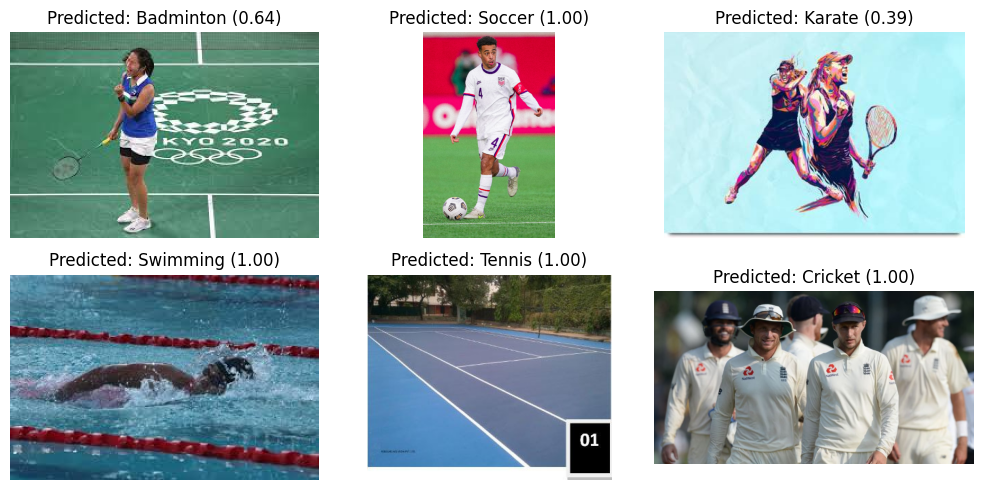

In [ ]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

# Load the test dataframe
df_test = pd.read_csv(TEST_CSV)

# Select a few random images from the test set
num_samples_to_show = 6
random_test_samples = df_test.sample(num_samples_to_show)

print(f"\nTesting predictions on {num_samples_to_show} random images from the test set:")

plt.figure(figsize=(10, 5))

for i, row in enumerate(random_test_samples.values):
    img_id = row[0] # Get the image_ID which is the first element in the row
    img_path = os.path.join(TEST_DIR, img_id)
    im = Image.open(img_path)

    # Make a prediction for the single image
    # FastAI's predict method handles opening the image and applying transforms
    pred, pred_idx, probs = learn.predict(img_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(im)
    plt.title(f"Predicted: {pred} ({probs[pred_idx]:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Huggingface Interface

In [ ]:
!pip install huggingface_hub
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import HfApi, Repository

SPACE_NAME = "canmizrakli/sports_image_classification"
api = HfApi()
api.create_repo(repo_id=SPACE_NAME, repo_type="space", space_sdk="gradio", exist_ok=False)

# Clone it locally
repo = Repository(local_dir="hf_space", clone_from=SPACE_NAME, repo_type="space")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, 